<font size=4>**Here is a detailed tutorial to show how to use PyCALI in Python by taking the data of Mrk 335 from ASAS-SN and ZTF as an example.**</font>

<font size=4>**First download the data of Mrk 335 in a CSV format from ASAS-SN website (https://asas-sn.osu.edu/) and ZTF website (ZTF g band; https://irsa.ipac.caltech.edu/Missions/ztf.html). Suppose the filenames are Mrk335_asas.csv and Mrk335_ztf.csv, respectively.** </font>

<font size=4>**Load these data and generate a formatted input file for PyCALI.** </font>

In [1]:
import numpy as np
import pycali
import matplotlib.pyplot as plt

In [2]:
ztf = pycali.convert_ztf("Mrk335_ztf.csv", rebin=1.0, errlimit=0.079, zeropoint=3.92e-9)
# rebin:  whether rebin the points. rebin=True: rebinning interval of one day; rebin=float: adjust rebinning interval to "rebin" day.
# errlimit: discard these points with errors larger than this limit
# unit is the zero-magnitude flux density
# return a dict
    
asas = pycali.convert_asassn("Mrk335_asas.csv", rebin=1.0, errlimit=0.079, diffcamera=False, zeropoint=3.92e-9)
# diffcamera: whether treat different cameras as different datasets
    
data = ztf | asas  # combine the two dicts
    
# write to a file named "Mrk335.txt"
pycali.format("Mrk335.txt", data, unit=1.0e-15, time_start = 2450000.0)
# unit: divide the flux densities with unit, namely, F -> F/unit.
# time_start: subtract time_start from the time, namely, t -> t-time_start

# if only use data in a time range, use
# pycali.format("Mrk335.txt", data, trange=(2458200, 2470000))

In [3]:
print("asas:", asas.keys())
print("ztf:", ztf.keys())
print("data:", data.keys())

asas: dict_keys(['asas_V', 'asas_g'])
ztf: dict_keys(['ztf_zg'])
data: dict_keys(['ztf_zg', 'asas_V', 'asas_g'])


<font size=4>**Now the input file has been created. Next run PyCALI to do intercalibration.**</font>

<font size=4>**This will take a while to run ..., better to directly run the python script "tests_mrk335.py", which shows the running status in the terminal.**</font>

=======Input parameters=========
             fname: 
             fcont: ./Mrk335.txt
             fline: 
             nmcmc: 10000
   scale_range_low: 0.5
    scale_range_up: 2
   shift_range_low: -1
    shift_range_up: 1
  syserr_range_low: 0
   syserr_range_up: 0.2
errscale_range_low: 0.5
 errscale_range_up: 2
   sigma_range_low: 0.0001
    sigma_range_up: 1
     tau_range_low: 1
      tau_range_up: 10000
       fixed_scale: 0
       fixed_shift: 0
      fixed_syserr: 1
 fixed_error_scale: 1
       fixed_codes: 
  fixed_scalecodes: 
         flag_norm: 1
         fixed_codes = 
    fixed_scalecodes = 
./Mrk335.txt
0  ztf_zg   300
1  asas_V   72
2  asas_g   506
  878 points, 3 codes.
# Start diffusive nested sampling.
# Creating level 1 with log likelihood = -6.294222e+04.
# Creating level 2 with log likelihood = -2.682141e+03.
# Creating level 3 with log likelihood = -3.558874e+02.
# Creating level 4 with log likelihood = 1.376803e+02.
# Creating level 5 with log likelihood = 5.84

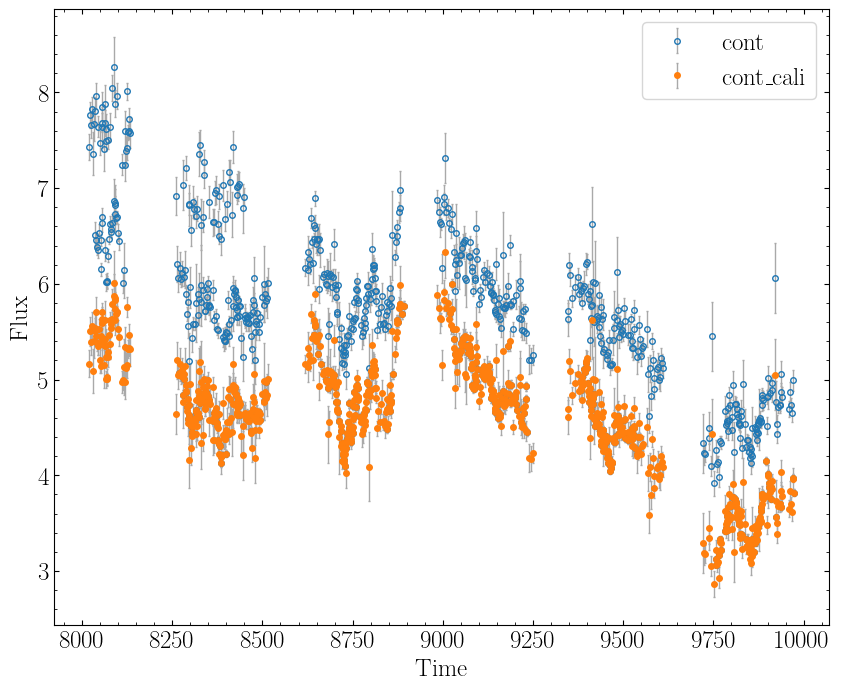

In [4]:
# setup configurations
cfg = pycali.Config()
cfg.setup(
      fcont="./Mrk335.txt",     # fcont is a string 
      nmcmc=10000, ptol=0.1,
      scale_range_low=0.5, scale_range_up=2.0,
      shift_range_low=-1.0, shift_range_up=1.0,
      syserr_range_low=0.0, syserr_range_up=0.2,
      errscale_range_low=0.5, errscale_range_up=2.0,
      sigma_range_low=1.0e-4, sigma_range_up=1.0,
      tau_range_low=1.0, tau_range_up=1.0e4,
      fixed_scale=False, fixed_shift=False,
      fixed_syserr=True, fixed_error_scale=True,
      fixed_codes=[], # fixed_codes is a list to specify the codes that need not to intercalibrate
                      # e.g., [1, 3], will fix 1st and 3rd codes
      fixed_scalecodes=[], # fixed_scalecodes is a list to specify the codes that need to fix scale (to 1)
                      # e.g., [1, 3], will fix scale of 1st and 3rd codes
      flag_norm=True, # whether do normalization before intercalibrating
      )
cfg.print_cfg()
######################################################
# do intercalibration
#
cali = pycali.Cali(cfg)  # create an instance
cali.mcmc()              # do mcmc
cali.get_best_params()   # calculate the best parameters
cali.output()            # print output
cali.recon()             # do reconstruction
    
# plot results to PyCALI_results.pdf
pycali.plot_results(cfg)
    
# a simple plot 
pycali.simple_plot(cfg)

<font size=4>**Take a look at the intercalibrated data**</font>

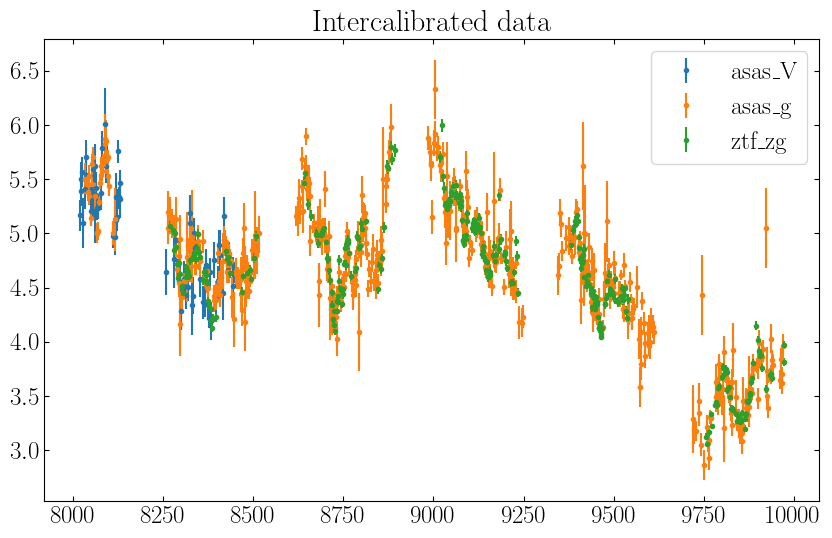

In [5]:
data_cali = np.loadtxt("Mrk335.txt_cali", usecols=(0, 1, 2))
code = np.loadtxt("Mrk335.txt_cali", usecols=(3), dtype=str)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for c in np.unique(code):
    idx = np.where(code == c)[0]
    ax.errorbar(data_cali[idx, 0],  data_cali[idx, 1], yerr=data_cali[idx, 2], ls='none', marker='o', markersize=3, label=c)

ax.legend()
ax.set_title("Intercalibrated data")
plt.show()

<font size=4>**There appears a number of outliers. We can discard these outliers as follows. This remove points with a deviation from the reconstruction larger than dev=5sigma and generate a new formatted data file. For example, if the original file name is Mrk335.txt, the new file name will be Mrk335_new.txt. **</font>

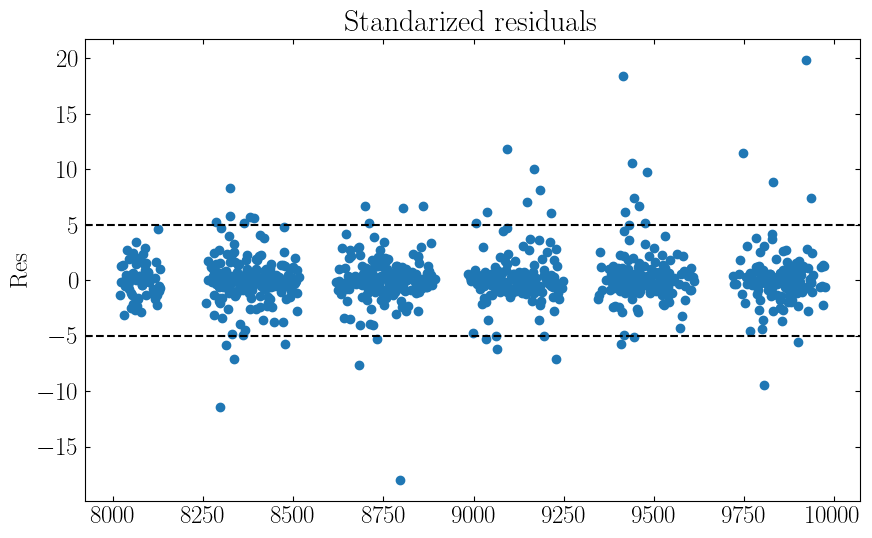

In [6]:
pycali.remove_outliers("./Mrk335.txt", dev=5, doplot=True)

<font size=4>**This will generate a new data file named "Mrk335_new.txt". Now redo the intercalibration on new data.**</font>

=======Input parameters=========
             fname: 
             fcont: ./Mrk335_new.txt
             fline: 
             nmcmc: 10000
   scale_range_low: 5.000000e-01
    scale_range_up: 2.000000e+00
   shift_range_low: -1.000000e+00
    shift_range_up: 1.000000e+00
  syserr_range_low: 0.000000e+00
   syserr_range_up: 2.000000e-01
errscale_range_low: 5.000000e-01
 errscale_range_up: 2.000000e+00
   sigma_range_low: 1.000000e-04
    sigma_range_up: 1.000000e+00
     tau_range_low: 1.000000e+00
      tau_range_up: 1.000000e+04
       fixed_scale: 0
       fixed_shift: 0
      fixed_syserr: 1
 fixed_error_scale: 1
       fixed_codes: 
  fixed_scalecodes: 
         flag_norm: 1
         fixed_codes = 
    fixed_scalecodes = 
./Mrk335_new.txt
0  asas_V   66
1  asas_g   469
2  ztf_zg   300
  835 points, 3 codes.
# Start diffusive nested sampling.
# Creating level 1 with log likelihood = -1.639466e+04.
# Creating level 2 with log likelihood = -1.077993e+03.
# Creating level 3 with log lik

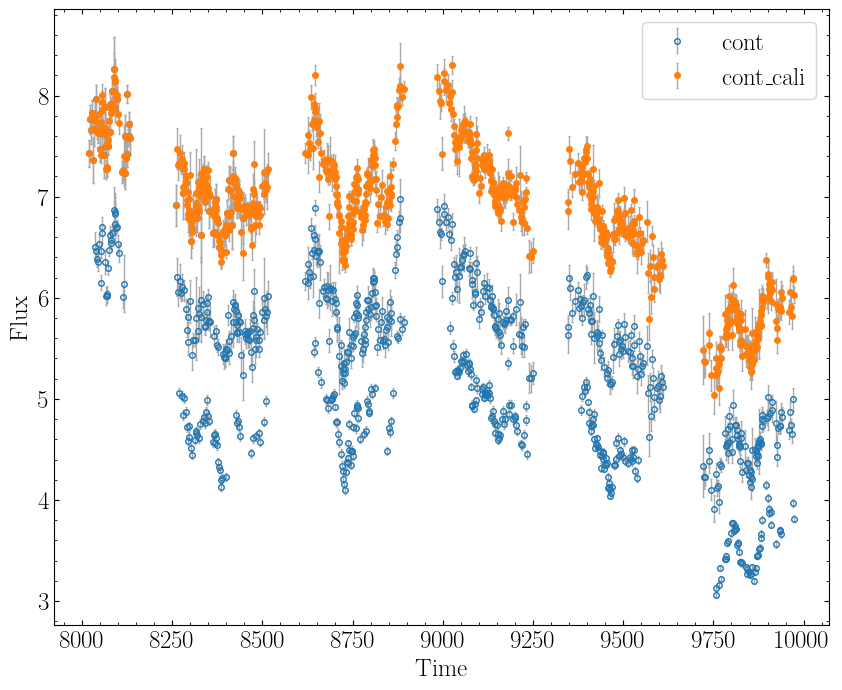

In [7]:
# setup configurations
cfg = pycali.Config()
cfg.setup(
      fcont="./Mrk335_new.txt",     # fcont is a string 
      nmcmc=10000, ptol=0.1,
      scale_range_low=0.5, scale_range_up=2.0,
      shift_range_low=-1.0, shift_range_up=1.0,
      syserr_range_low=0.0, syserr_range_up=0.2,
      errscale_range_low=0.5, errscale_range_up=2.0,
      sigma_range_low=1.0e-4, sigma_range_up=1.0,
      tau_range_low=1.0, tau_range_up=1.0e4,
      fixed_scale=False, fixed_shift=False,
      fixed_syserr=True, fixed_error_scale=True,
      fixed_codes=[], # fixed_codes is a list to specify the codes that need not to intercalibrate
                      # e.g., [1, 3], will fix 1st and 3rd codes
      fixed_scalecodes=[], # fixed_scalecodes is a list to specify the codes that need to fix scale (to 1)
                      # e.g., [1, 3], will fix scale of 1st and 3rd codes
      flag_norm=True, # whether do normalization before intercalibrating
      )
cfg.print_cfg()
######################################################
# do intercalibration
#
cali = pycali.Cali(cfg)  # create an instance
cali.mcmc()              # do mcmc
cali.get_best_params()   # calculate the best parameters
cali.output()            # print output
cali.recon()             # do reconstruction
    
# plot results to PyCALI_results.pdf
pycali.plot_results(cfg)
    
# a simple plot 
pycali.simple_plot(cfg)

<font size=4>**Take a look at the newly intercalibrated data**</font>

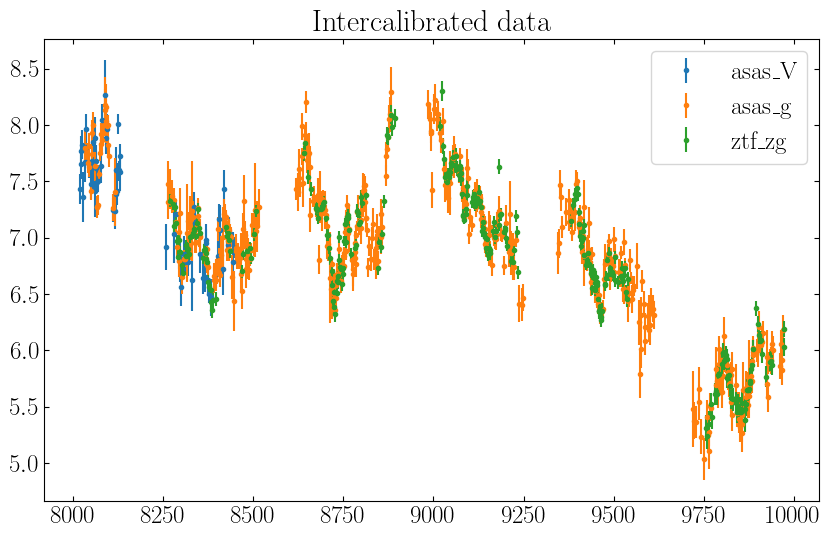

In [8]:
data_cali_new = np.loadtxt("Mrk335_new.txt_cali", usecols=(0, 1, 2))
code = np.loadtxt("Mrk335_new.txt_cali", usecols=(3), dtype=str)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for c in np.unique(code):
    idx = np.where(code == c)[0]
    ax.errorbar(data_cali_new[idx, 0],  data_cali_new[idx, 1], yerr=data_cali_new[idx, 2], ls='none', marker='o', markersize=3, label=c)

ax.legend()
ax.set_title("Intercalibrated data")
plt.show()